## Capstone Final Project - Machine Learning Engineer.

## Bricks Sorter App

The idea for this project is to come up with an image recognition model trained on lego bricks to be able to recognize various types of bricks like style and size.

### Code Sections/Components

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Working with the Dataset (Import, Preprocessing and savepoints)
* [Step 1](#step1): Convolutional Neural Network Model for legos/bricks recognition
* [Step 2](#step2): Training Our Model
* [Step 3](#step3): Test Your Algorithm
* [Step 4](#step4): Resnet50 on Legos?

---
<a id='step0'></a>
## Step 0: Working with the Dataset


### Import Bricks Dataset

Here I will load the datasets for the brick images I captured from my phone. The images were first converted through the convert utilty (see convert.py in the git repo). After conversions, the images were spread into train, test and validations steps to give us a confidence on how we are doing with recognizing images of different types.

In [219]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    brick_files = np.array(data['filenames'])
    brick_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return brick_files, brick_targets

# load train, test, and validation datasets
print('Starting loading train files !')
train_files, train_targets = load_dataset('all-images/keep4/train')
print('Starting loading valid files !')
valid_files, valid_targets = load_dataset('all-images/keep4/valid')
print('Starting loading test_target files !')
test_files, test_targets = load_dataset('all-images/keep4/test')

# load list of brick names
brick_names = [item.split('/')[2] for item in sorted(glob("all-images/keep4/train/*/"))]

# print statistics about the dataset
print (brick_names)
print('There are %d total brick categories.' % len(brick_names))
print('There are %s total brick images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training brick images.' % len(train_files))
print('There are %d validation brick images.' % len(valid_files))
print('There are %d test brick images.'% len(test_files))

Starting loading train files !
Starting loading valid files !
Starting loading test_target files !
['train', 'train', 'train']
There are 3 total brick categories.
There are 292 total brick images.

There are 232 training brick images.
There are 31 validation brick images.
There are 29 test brick images.


### Pre-process the Data

In order for the data to be properly read and understood by various layes of our model (and other pre-trained models), we need to do some preprocessing. 

#### Image as 'Tensor'

As you will see in the report, we've chosen to write a Convolutional Neural Network to train and recognize images. For the neural network architecture's "backend" we've chosen TensorFlow as our backend. When using TensorFlow as backend, Keras CNNs require a 4D array (also refered to as "4D tensor") as input. This 4D tensor has shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The other wrapper `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in our dataset!


#### Pixels compuation

Down the line when we will use Resnet50, we need to do some other pre_processing as well. Here are the details.

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels. All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as  [103.939,116.779,123.68]  and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function preprocess_input. The 4D Tensor is supplied to the `preprocess_input` function from resnet50 package.

The preproces_input function is form resnet50, I will show down below how Resnet50 processing uses it.


#### Rescaling

We also rescale the images by dividing every pixel in every image by 255.


In [220]:
from tensorflow.keras.preprocessing import image                  
from tqdm import tqdm

# Convert an image from a path to a 4D Tensor with shape (1, 255, 255, 3)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

# Convert multiple shapes from image paths to 4D Tensor with shape (nb_samples, 255, 255, 3)
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)



---
<a id='step2'></a>
## Step 2: Training our model (from the scratch)
---
Now is the time to write our own CNN architecture to try to predict the correct categories of the image.

1x1 Bricks | 1x2 Triange Bricks
- | - 
<img src="samples/1_by_1_1.jpg" width="300"> | <img src="samples/1_by_2_triangle_1.jpg" width="300">

It can easily be seen that many of the categories of bricks are actually very close in look to each other.


1x8 Bricks | 1x6 Bricks
- | -
<img src="samples/1_by_8_2.jpg" width="300"> | <img src="samples/1_by_6_2.jpg" width="300">


### Pre-process the Data

Down the line when we will use Resnet50, we need to do some other pre_processing as well. Here are the details.

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels. All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as  [103.939,116.779,123.68]  and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function preprocess_input. If you're curious, you can check the code for preprocess_input here.

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions. This is accomplished with the predict method, which returns an array whose  𝑖 -th entry is the model's predicted probability that the image belongs to the  𝑖 -th ImageNet category. This is implemented in the ResNet50_predict_labels function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this dictionary.

In [221]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 29/29 [00:00<00:00, 541.82it/s]


---
<a id='step1'></a>
## Step 1: Convolutional Neural Network Model for legos/bricks recognition
----
### The Model Architecture

Here we now create our own CNN Architecture to train a model that can identify our bricks.

        model.summary()

I've run the training algorithm on a p2.xlarge AWS instance with GPU processing power. This tremendously saves time required to train the model.

Here are the details of the various layers of my training model.

__Answer:__ 

1. The architecture I chose has 3 convolutional layers separated by two pooling layers. The Pooling layers will help with the dimensionality reduction while the conv layers will learn from the high level features. The convolutional layers help the machine learn key aspects of an image like edge detection, blurring, sharperning, noise detection etc. The pooling layer help in reducing the dimensionality without loosing the key features.

2. The results of the convultional layers are to be fed to a dense or fully connected layer that will generate the final prediction. But before we feed to the dense layer, we need to flatten the output of our conv/pooling layers.

3. For this, we use the flatten layer. I've used one flatten layer that 

4. Dropout layer has been introduced after the flatten layer to reduce the overfitting that may have caused during the learning. This helps the model to get generalized much better.

5. Finally (as mentioned in step 2), the results are fed into the dense layers. I choose two dense layers for getting better prediction as I was running it on GPU in AWS.

6. For probablities of prediction, I've used the softmax function with a set of 133 nodes on the last layer and chose relu in the 2nd last layer on 212 fully connected layer. In fact relu was used for all other layers.


In [222]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(212, activation='relu'))
model.add(Dense(133, activation='softmax'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 24, 24, 128)     

### Compile the Model

In [231]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Now we will train our model.

In [232]:
from tensorflow.keras.callbacks import ModelCheckpoint  
import matplotlib.pyplot as plt  

epochs = 12

# 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.prj.hdf5', 
                               verbose=1, save_best_only=True)

# Fit the model.
print ('Checkpoints Step !!!')
history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)


Checkpoints Step !!!
Train on 232 samples, validate on 31 samples
Epoch 1/12
230/232 [============================>.] - ETA: 0s - loss: 8.2255 - accuracy: 0.3435
Epoch 00001: val_loss improved from inf to 1.16989, saving model to saved_models/weights.best.prj.hdf5
232/232 [==============================] - 14s 60ms/sample - loss: 8.1640 - accuracy: 0.3448 - val_loss: 1.1699 - val_accuracy: 0.3548
Epoch 2/12
230/232 [============================>.] - ETA: 0s - loss: 1.1209 - accuracy: 0.3478
Epoch 00002: val_loss improved from 1.16989 to 1.15697, saving model to saved_models/weights.best.prj.hdf5
232/232 [==============================] - 13s 57ms/sample - loss: 1.1211 - accuracy: 0.3491 - val_loss: 1.1570 - val_accuracy: 0.3548
Epoch 3/12
230/232 [============================>.] - ETA: 0s - loss: 1.1431 - accuracy: 0.3391
Epoch 00003: val_loss did not improve from 1.15697
232/232 [==============================] - 13s 57ms/sample - loss: 1.1442 - accuracy: 0.3362 - val_loss: 1.3140 - v

In [233]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow import keras
def show_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    return imgplot

def predict(image_path):
    img = preprocess_input(path_to_tensor(image_path))
    indx = np.argmax(model.predict(img))
    print('brick name {}'.format(brick_names[indx]))
    return show_img(image_path)



In [234]:
conv_layers = list()    
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
        # summarize output shape
    print(i, layer.name, layer.output.shape)   

(0, 'conv2d_76', TensorShape([None, 222, 222, 32]))
(2, 'conv2d_77', TensorShape([None, 109, 109, 64]))
(4, 'conv2d_78', TensorShape([None, 52, 52, 128]))
(6, 'conv2d_79', TensorShape([None, 24, 24, 128]))


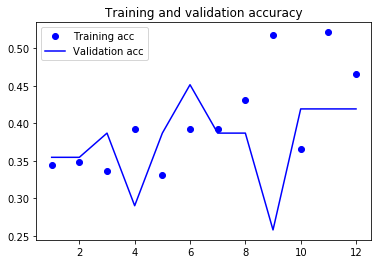

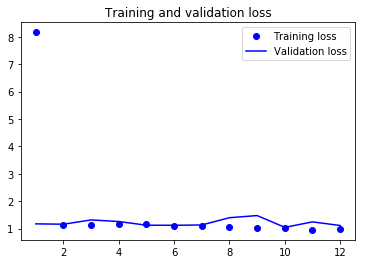

In [235]:
# Plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show() 

In [236]:
model.load_weights('saved_models/weights.best.prj.hdf5')

### Test the Model

Now we test out our model to make sure we have an acceptable accuracy.

In [237]:
import cv2 
# index of the predicted category of bricks
brick_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(brick_predictions)==np.argmax(test_targets, axis=1))/len(brick_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)



Test accuracy: 34.0000%


['loss', 'val_accuracy', 'val_loss', 'accuracy']


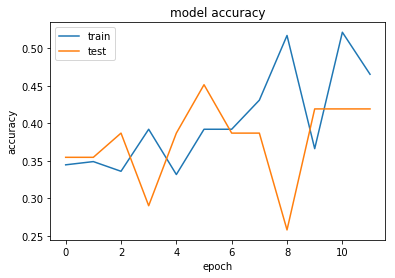

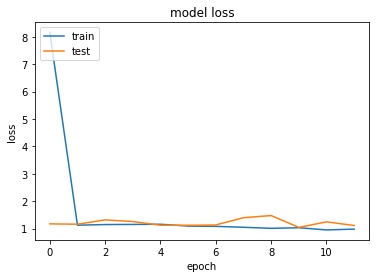

In [238]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

max_pooling2d_76
Shape of the filter is (3, 3, 32, 64)


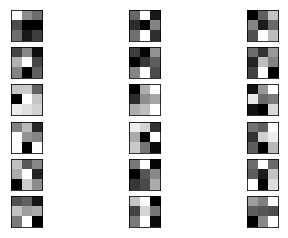

In [239]:
# cannot easily visualize filters lower down
from tensorflow.keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
#model = VGG16()
print model.layers[1].name
# retrieve weights from the second hidden layer
filters, biases = model.layers[2].get_weights()
print ('Shape of the filter is {}'.format(filters.shape))
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

In [240]:
# plot feature map of first conv layer for given image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

def draw_layer_features(layer_number):
    model_till_layer_two = Model(inputs=model.inputs, outputs=model.layers[layer_number].output)
    model_till_layer_two.summary()
    # load the image with the required shape
    img = load_img('samples/1_by_1_1.jpg', target_size=(224, 224))
    # convert the image to an array
    img = img_to_array(img)
    # expand dimensions so that it represents a single 'sample'
    img = expand_dims(img, axis=0)
    # prepare the image (e.g. scale pixel values for the vgg)
    img = preprocess_input(img)
    # get feature map for first hidden layer
    feature_maps = model_till_layer_two.predict(img)
    print ('Feature_maps dimention {}'.format(feature_maps.shape))
    # plot all 64 maps in an 8x8 squares
    square = 8
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76_input (InputLayer) [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 109, 109, 64)      18496     
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________
Feature_maps dimention (1, 109, 109, 64)


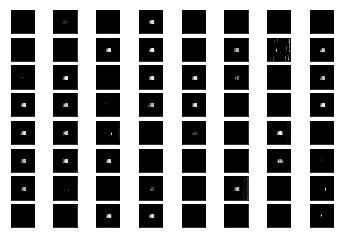

In [241]:
draw_layer_features(2)

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76_input (InputLayer) [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 52, 52, 128)       73856     
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
______________________________________________________

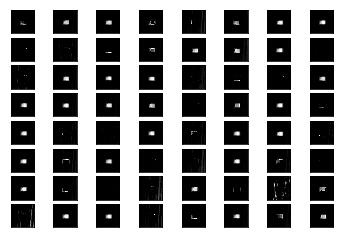

In [242]:
draw_layer_features(4)

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76_input (InputLayer) [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 26, 26, 128)       0  

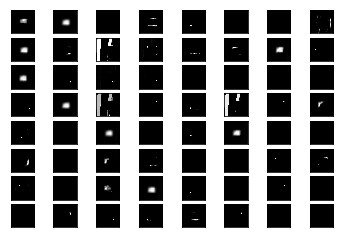

In [243]:
draw_layer_features(6)

---
<a id='step3'></a>
## Step 3: Test Your Algorithm
---

predicted name 1_by_1


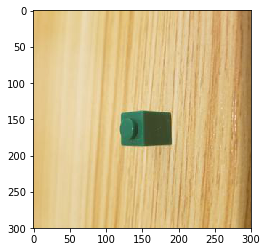

In [53]:
predict('samples/1_by_1_1.jpg')

predicted name 1_by_6


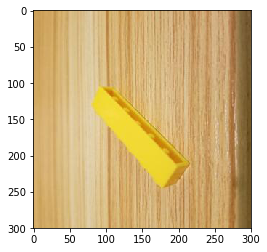

In [54]:
predict('samples/1_by_6_1.jpg')

predicted name 1_by_6


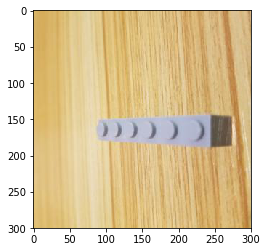

In [55]:
predict('samples/1_by_6_2.jpg')

predicted name 1_by_2


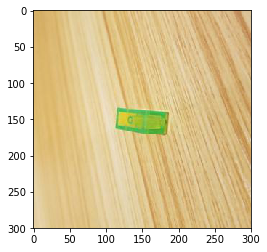

In [56]:
predict('samples/1_by_2_2.jpg')

predicted name 1_by_1


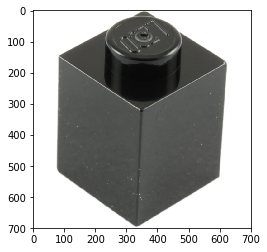

In [57]:
predict('samples/1_by_1_from_outside.jpg')

predicted name 1_by_2


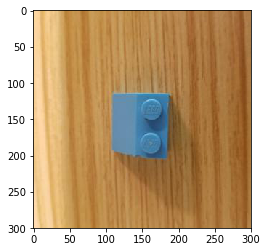

In [59]:
predict('samples/1_by_2_triangle_1.jpg')

---
<a id='step4'></a>
## Step 4: Resnet50 on Legos?

Though there is no category in the [ImageNet] for Legos/bricks, I was interested to see what a pre-trained model like [ResNet-50] think of the Legos. Here I will use [ResNet-50] In this section, I will use this pre-trained model and supply a few images to it to find out what it thinks a lego brick most closely looks like.

In [62]:
from tensorflow.keras.applications.resnet50 import ResNet50

# define ResNet50 model 
ResNet50_model = ResNet50(weights='imagenet')

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [67]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))


In [64]:
what_is_this_image = ResNet50_predict_labels('samples/1_by_8_1.jpg')
print ('The image is {}'.format(what_is_this_image))

The image is 626


769 -- That's a lighter/ignitor in the categories (https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). If you look at an oblonged 1_by_8 image, it does actuall look like a lighter/igniter. Lets try some more.


In [68]:
what_is_this_image = ResNet50_predict_labels('samples/1_by_8_2.jpg')
print ('The image is {}'.format(what_is_this_image))

The image is 769


769 in the categories in a 'prayer mat'. This also is close.

In conclusion, I just for the sake of fun used resent50 to test how it sees my bricks - it very closely mapped ito the categories that did look like those.

We could may be use various layers of the Resnet50 in different settings to improve our brick prediction. The keras and tensorflow api allows for this pick and drop of parts of a model.